# Исследование рынка общественного питания Москвы

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. 

Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

**Цель:** Исследовать рынок общественного питания Москвы и дать рекомендации о виде заведения, количество посадочных мест и районе расположения.

Описание данных:
* id — идентификатор объекта;
* object_name — название объекта общественного питания;
* chain — сетевой ресторан;
* object_type — тип объекта общественного питания;
* address — адрес;
* number — количество посадочных мест.


## Изучение данных из файла

Установим модуль Dadata для стандартизации адресов

In [1]:
pip install dadata -U

  Attempting uninstall: anyio
    Found existing installation: anyio 2.2.0
    Uninstalling anyio-2.2.0:
      Successfully uninstalled anyio-2.2.0
Note: you may need to restart the kernel to use updated packages.


И еще folium для геопространственной визуализации

In [2]:
pip install folium -U

Note: you may need to restart the kernel to use updated packages.


И обновим плотли

In [3]:
pip install plotly -U

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import re
import folium
import folium.plugins as plugins
import requests

import plotly.io as pio
pio.renderers.default = 'svg'

from dadata import Dadata
from tqdm.notebook import tqdm

pd.set_option('chained_assignment', None)

In [5]:
try:
    rest_data = pd.read_csv('https://code.s3.yandex.net/datasets/rest_data.csv')
except Exception as err:
    print('Ошибка:', err)

In [6]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


## Предобработка данных

In [7]:
def primary_info(df):
    display(df.head())
    print()
    print('Проверка на пропущенные значения:')
    display(pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print('----------------')
    print()
    print('Проверка типа данных на корректность:')
    print(df.info())
    print('----------------')
    print()
    print('Количество дубликатов:', df.duplicated().sum())

In [8]:
primary_info(rest_data)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50



Проверка на пропущенные значения:


,0
id,0.000000
object_name,0.000000
chain,0.000000
object_type,0.000000
address,0.000000
number,0.000000


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None
----------------

Количество дубликатов: 0


Полных дубликатов нет, проверим датафрейм без столбца id

In [9]:
rest_data[rest_data.loc[:, ('object_name', 'chain', 'object_type', 'address', 'number')].duplicated()]

,id,object_name,chain,object_type,address,number
2381,28611,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",100
3481,20914,Буфет Мади,нет,буфет,"город Москва, Ленинградский проспект, дом 64",40
4431,23759,СТОЛОВАЯ ГБОУ города Москвы № 384,нет,буфет,"город Москва, Беловежская улица, дом 67",100
4537,23391,Столовая «Комбинат питания КОСМОС»,нет,столовая,"город Москва, Новозаводская улица, дом 12/11",15
5059,20021,LIFT,нет,кафе,"город Москва, Багратионовский проезд, дом 7, к...",20
...,...,...,...,...,...,...
14578,222932,Старый Баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120
14596,204947,Буфет при кинотеатре,нет,буфет,"город Москва, Ореховый бульвар, дом 22А",0
14844,219518,Sushi-Make,нет,предприятие быстрого обслуживания,"город Москва, Ярцевская улица, дом 19",0
15173,218542,Кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корп...",0


Вот и они - 82 дубликата. Удалим их

In [10]:
rest_data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number'], inplace=True)

In [11]:
rest_data[rest_data.loc[:, ('object_name', 'chain', 'object_type', 'address')].duplicated()]

,id,object_name,chain,object_type,address,number
115,28614,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
580,149205,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39
1409,151267,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",45
2375,28604,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, стр...",150
...,...,...,...,...,...,...
15006,219563,Кафе,нет,кафе,"город Москва, Береговой проезд, дом 5А, корпус 1",25
15007,219569,Кафе,нет,кафе,"город Москва, Береговой проезд, дом 5А, корпус 1",2
15216,214468,Макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 87Б",0
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20


Если убрать столбец с количеством посадочных мест, то появятся еще 88 дубликатов. Но ввиду недостаточной информации, их обработать не получится. Это могут быть как реальные дубликаты, к примеру, ресторан увеличил/уменьшил количество посадочных мест, добавили новую информацию, а старую запись удалить забыли, так и ресторан с несколькими залами - к примеру, банкетный и гостевой залы с разным количеством посадочных мест.

Приведем все названия заведений к нижнему регистру, сохранив заглавной первую букву

In [12]:
rest_data['object_name'] = rest_data['object_name'].str.capitalize()

In [13]:
rest_data

,id,object_name,chain,object_type,address,number
0,151635,Сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,Пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


**Вывод**
* Пропущенных значений нет
* С типами данных все в порядке
* Удалили 82 дубликата
* Исправили регистр в названиях заведений

Можно приступать к анализу

## Анализ данных

### Исследуем соотношение видов объектов общественного питания по количеству.


In [14]:
object_type_count = rest_data['object_type'].value_counts().reset_index()
object_type_count.columns = ['object_type', 'count']
object_type_count

,object_type,count
0,кафе,6071
1,столовая,2584
2,ресторан,2282
3,предприятие быстрого обслуживания,1898
4,бар,855
5,буфет,577
6,кафетерий,395
7,закусочная,349
8,магазин (отдел кулинарии),273


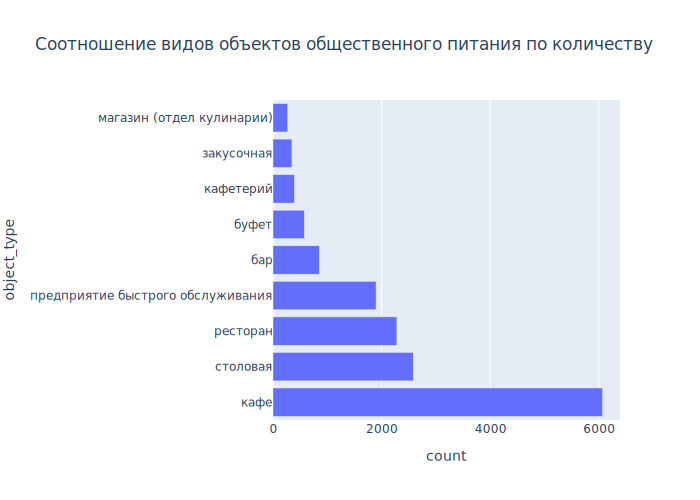

In [15]:
fig = px.bar(object_type_count,
             x='count', y='object_type', orientation='h',
             title='Соотношение видов объектов общественного питания по количеству')

fig.show()

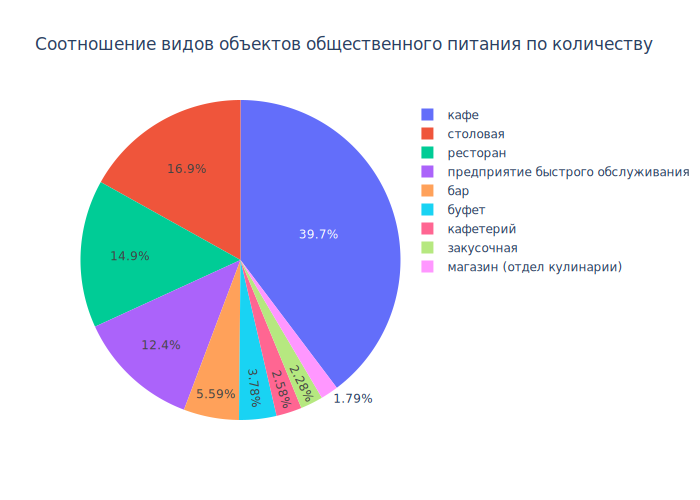

In [16]:
fig = px.pie(object_type_count, values='count', names='object_type', 
             title='Соотношение видов объектов общественного питания по количеству')

fig.show()

* Абсолютный лидер в этой категории - кафе. Почти 40% (6099) всех заведений общественного питания приходится на него;
* Далее по популярности - столовые (16.8%) и рестораны (14.9%);
* Наименее популярны по количеству заведений - это отделы кулинарии (1.78%) и закусочные (2.34%).

### Исследуем соотношение сетевых и несетевых заведений по количеству.


In [17]:
chain_count = rest_data['chain'].value_counts().reset_index()
chain_count.columns = ['chain', 'count']
chain_count

,chain,count
0,нет,12320
1,да,2964


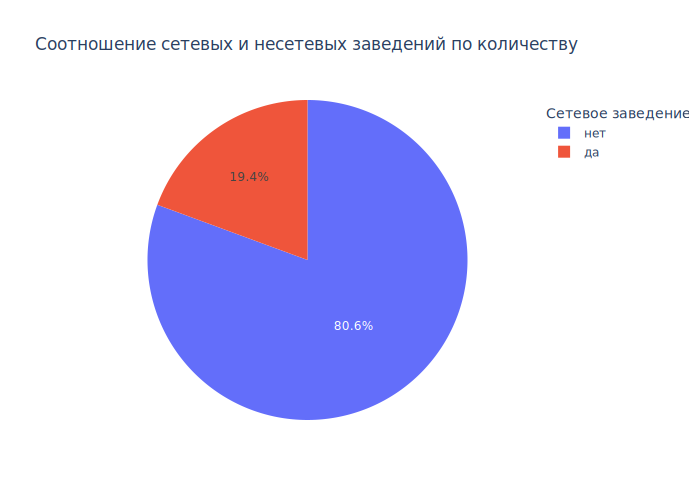

In [18]:
fig = px.pie(chain_count, values='count', names='chain', 
             title='Соотношение сетевых и несетевых заведений по количеству')

fig.update_layout(
    legend_title_text='Сетевое заведение'
)
fig.show()

Подавляющее большинство заведений (80%) - несетевые.

### Для какого вида объекта общественного питания характерно сетевое распространение?

In [19]:
object_type_chain_count = (
    rest_data
        .query('chain == "да"')
        .groupby('object_type', as_index=False)
        .agg({'id':'count'})
        .rename(columns={'id':'count'})
        .sort_values(by='count')
)

object_type_chain_count

,object_type,count
8,столовая,3
1,буфет,11
0,бар,37
4,кафетерий,52
2,закусочная,56
5,магазин (отдел кулинарии),78
7,ресторан,543
6,предприятие быстрого обслуживания,788
3,кафе,1396


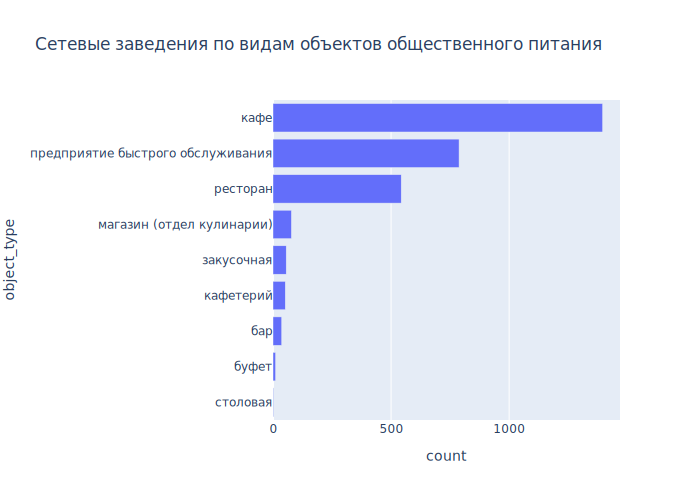

In [20]:
fig = px.bar(object_type_chain_count,
             x='count', y='object_type', orientation='h',
             title='Сетевые заведения по видам объектов общественного питания')

fig.show()

Больше всего сетевых заведений у кафе, но в данном случае, я считаю, лучше посчитать не в абсолютных показателях, а в относительных

In [21]:
object_type_chain_rate = pd.merge(object_type_chain_count, object_type_count, on='object_type')
object_type_chain_rate.rename(columns={'count_x':'chain_count',
                                       'count_y':'total_count'}, inplace=True)

object_type_chain_rate['rate'] = object_type_chain_rate['chain_count'] / object_type_chain_rate['total_count']
object_type_chain_rate

,object_type,chain_count,total_count,rate
0,столовая,3,2584,0.001161
1,буфет,11,577,0.019064
2,бар,37,855,0.043275
3,кафетерий,52,395,0.131646
4,закусочная,56,349,0.160458
5,магазин (отдел кулинарии),78,273,0.285714
6,ресторан,543,2282,0.237949
7,предприятие быстрого обслуживания,788,1898,0.415174
8,кафе,1396,6071,0.229946


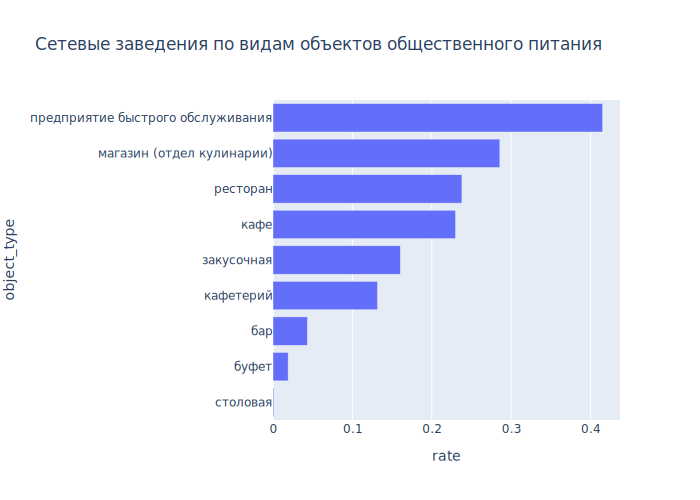

In [22]:
fig = px.bar(object_type_chain_rate.sort_values(by='rate'),
             x='rate', y='object_type', orientation='h',
             title='Сетевые заведения по видам объектов общественного питания')

fig.show()

Ну вот, выходит для кафе вовсе не характерно сетевое распространение.

А лидер здесь - предприятия быстрого обслуживания. Почти 42% из всех организаций - сетевые. Оно и логично - такие заведения относительно легко масштабируются и пользуются спросом для франчайзинга.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?


In [23]:
df = (
    rest_data
        .query('chain == "да"')
        .groupby('object_name')
        .agg({'id':'count',
              'number':'mean'})
        .rename(columns={'id':'object_count'})
)

df

,object_count,number
object_name,,
Beverly hills diner,1,88.000000
Bierloga,1,75.000000
Black & white,1,40.000000
Bocconcino,3,66.666667
Boobo,1,46.000000
...,...,...
Якитория и ян примус,1,282.000000
Ямми микс,1,2.000000
Ян примус,1,300.000000


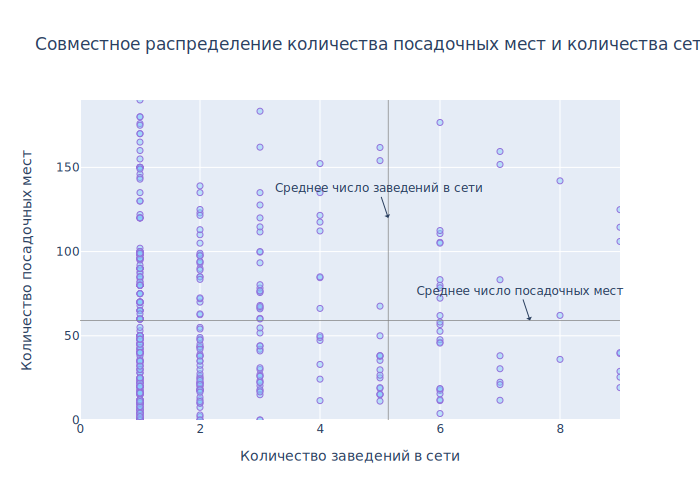

In [24]:
fig = px.scatter(df, x='object_count', y='number',
                title='Совместное распределение количества посадочных мест и количества сетевых заведений')

fig.update_layout(
    xaxis_title='Количество заведений в сети',
    yaxis_title='Количество посадочных мест',
    xaxis_range=[0,9],
    yaxis_range=[0, (df['number'].quantile(.75) - df['number'].quantile(.25)) * 3]
)

fig.update_traces(
    marker=dict(
            color='rgba(135, 206, 250, 0.5)',
            line=dict(
                color='MediumPurple',
                width=1
            )
        )
)

fig.add_hline(y=df['number'].mean(), line_width=0.7, line_color='grey')
fig.add_vline(x=df['object_count'].mean(), line_width=0.7, line_color='grey')

fig.add_annotation(x=7.5, y=df['number'].mean(),
            text='Среднее число посадочных мест',
            showarrow=True,
            arrowhead=1)

fig.add_annotation(x=df['object_count'].mean(), y=120,
            text='Среднее число заведений в сети',
            showarrow=True,
            arrowhead=1)

fig.show()

Выходит, если взять случайное сетевое заведение, то вероятнее всего это будет сеть с малым числом заведений в сети и небольшим числом посадочных мест.

### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест?


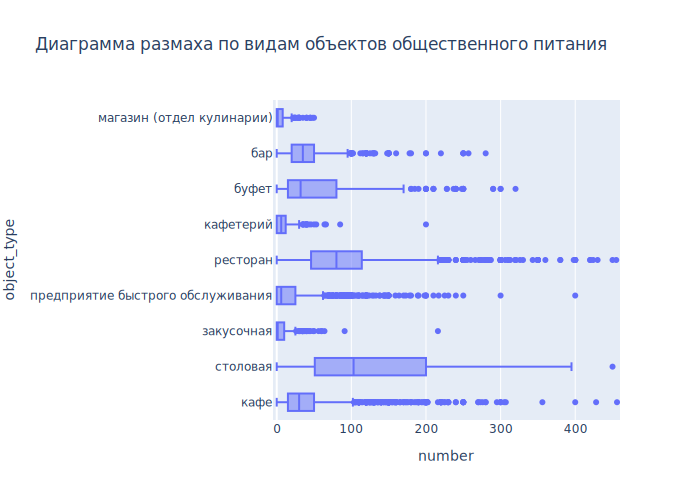

In [25]:
fig = px.box(rest_data, x='number', y='object_type', orientation='h',
             title='Диаграмма размаха по видам объектов общественного питания')

fig.update_layout(
    xaxis_range=[-5,460]
)
fig.show()

В среднем самое большое количество посадочных мест в столовых - 103 места. На 2 месте рестораны - 80 мест.

### Выделим в отдельный столбец информацию об улице из столбца address.

Это можно легко сделать с помощью Dadata или Yandex decoder'а, но они платные, поэтому сделаю через регулярные выражения

In [26]:
words = ['улица','ул', 'переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия', 'микрорайон',
         'квартал', 'деревня', 'посёлок', 'километр', 'территория', 'корпус']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest_data['street'] = rest_data['address'].str.extract(str_pat, flags=re.I)
rest_data

,id,object_name,chain,object_type,address,number,street
0,151635,Сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,Пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,22-й километр


Проверим пропуски

In [27]:
rest_data.query('street != street')

,id,object_name,chain,object_type,address,number,street
859,23601,Буфет - гбоу сош № 64,нет,буфет,"Партизанская улица, дом 30",100,NaN
860,23604,Буфет - гбоу 60,нет,буфет,"Партизанская улица, дом 30",100,NaN
1405,20199,Это,нет,кафе,"город Москва, город Зеленоград, корпус 401",35,NaN
1406,68113,Френдс,нет,кафе,"город Москва, город Зеленоград, корпус 435",34,NaN
1407,20105,Кафе «граф монте-кристо»,нет,кафе,"город Москва, город Зеленоград, корпус 436",40,NaN
...,...,...,...,...,...,...,...
14468,205933,Кафе «империя бургеров»,нет,кафе,"город Москва, город Зеленоград, корпус 1106Е",24,NaN
14470,220595,Пекарня № 1,нет,кафетерий,"город Москва, город Зеленоград, корпус 1627",6,NaN
14473,220978,Бар суши takai,нет,кафе,"город Москва, город Зеленоград, корпус 1602А",28,NaN
14478,211676,Никольский,нет,ресторан,"город Москва, город Зеленоград, корпус 532",120,NaN


Осталось 188 пропусков, это 1% от наших данных. Думаю, на дальнейшее исследование это не должно повлиять

In [28]:
rest_data = rest_data.query('street == street')
rest_data

,id,object_name,chain,object_type,address,number,street
0,151635,Сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,Пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,22-й километр


### Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией для ответа на вопрос — в каких районах Москвы находятся эти улицы?


In [29]:
top10_street = (
    rest_data
        .groupby('street', as_index=False)
        .agg({'id':'count'})
        .rename(columns={'id':'count'})
        .sort_values(by='count', ascending=False)
        .head(10)
)

top10_street

,street,count
1517,проспект Мира,204
1044,Профсоюзная улица,178
719,Ленинградский проспект,170
1029,Пресненская набережная,167
434,Варшавское шоссе,160
722,Ленинский проспект,146
1513,проспект Вернадского,126
709,Кутузовский проспект,114
639,Кировоградская улица,107
1313,Ходынский бульвар,102


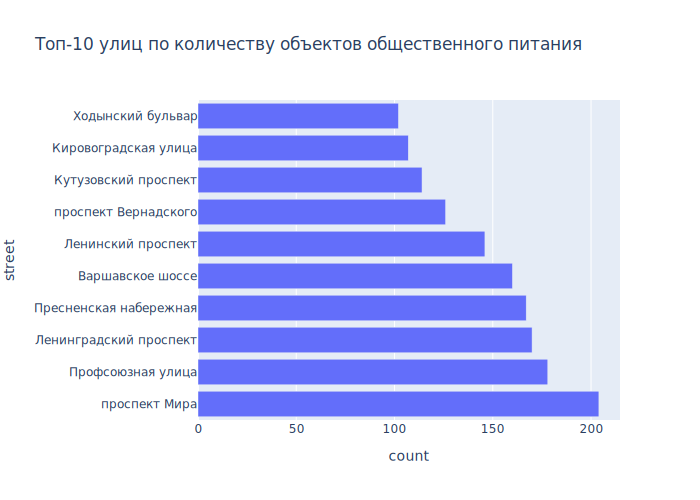

In [30]:
fig = px.bar(top10_street,
             x='count', y='street', orientation='h',
             title='Топ-10 улиц по количеству объектов общественного питания')

fig.show()

А вот тут уже можно обратиться к Dadata. Функция возвращает нам район и координаты по улице

**Функция может не сработать, потому что лимит на количество бесплатных запросов. Поэтому отсюда запускать ничего не надо (да и не получится, токена нет)**

**Я сохраню полученный мною df, выложу его на файлообменник и прочитаю ниже**

In [ ]:
token = 'api'
secret = 'secret-key'
dadata = Dadata(token, secret)

In [ ]:
def get_district_dadata(row):
    query = dadata.clean("address", row['street'])
  
    try:
        return pd.Series([query['city_district_with_type'], float(query['geo_lon']), float(query['geo_lat'])])
    except:
        return pd.Series([0, 0, 0])

In [ ]:
tqdm.pandas()

top10_street[['district', 'longitude', 'latitude']] = top10_street.progress_apply(get_district_dadata, axis=1)

In [ ]:
top10_street.to_csv('top10_street.csv', encoding='utf-8', index=False)

**Отсюда можно запускать**

In [31]:
url = 'https://drive.google.com/file/d/1no_ek_Yj0JNGXhdDss6oMVP6jLoUz8s5/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
top10_street = pd.read_csv(path)

In [32]:
top10_street

,street,count,district,longitude,latitude
0,проспект Мира,204,р-н Марьина роща,37.637937,55.812368
1,Профсоюзная улица,178,р-н Черемушки,37.532511,55.649520
2,Ленинградский проспект,170,р-н Сокол,37.545604,55.794196
3,Пресненская набережная,167,р-н Пресненский,37.541949,55.747144
4,Варшавское шоссе,160,р-н Чертаново Южное,37.604053,55.599992
5,Ленинский проспект,146,р-н Проспект Вернадского,37.537038,55.682601
6,проспект Вернадского,126,р-н Ломоносовский,37.515248,55.681664
7,Кутузовский проспект,114,р-н Дорогомилово,37.509035,55.735108
8,Кировоградская улица,107,р-н Чертаново Южное,37.604962,55.614296
9,Ходынский бульвар,102,р-н Хорошевский,37.535248,55.785717


In [33]:
top10_street_list = list(top10_street['street'])
top10_street_list

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Кировоградская улица',
 'Ходынский бульвар']

In [34]:
top10_address = (
    rest_data
        .query('street in @top10_street_list')['address']
        .value_counts()
        .reset_index()
        .rename(columns={'index':'street',
                         'address':'count'})
)

top10_address

,street,count
0,"город Москва, Ходынский бульвар, дом 4",95
1,"город Москва, Пресненская набережная, дом 2",63
2,"город Москва, проспект Мира, дом 211, корпус 2",60
3,"город Москва, Кировоградская улица, дом 13А",52
4,"город Москва, Кутузовский проспект, дом 57",40
...,...,...
520,"город Москва, проспект Вернадского, дом 13",1
521,"город Москва, проспект Мира, дом 39А",1
522,"город Москва, Варшавское шоссе, дом 132А",1
523,"город Москва, Ленинградский проспект, дом 75, ...",1


**Здесь всё так же, как сверху. Запускать не надо, я дальше все сохранил.**

Строк много, Dadata исчерпчал свой лимит, будем теперь использовать Yandex Geocoder.

Функция заменяет пробелы в названиях улиц на '+', вставляет в geocode url, далее получает json, парсит, вытаскивает координаты, преобразует в float, возвращает series с координатами, а мы их сохраням в соответствующие столбцы.

Используем конструкцию try-except на случай, если url по улице не откроется

In [ ]:
API = 'api-key'

In [ ]:
def get_pos_yandexgeo(row):
    street = '+'.join(row['street'].split())

    url = 'https://geocode-maps.yandex.ru/1.x'
    params = {'geocode':'Москва,{}'.format(street),
              'format':'json',
              'apikey': API}

    r = requests.get(url, params=params).json()
    
    try:
        pos = r['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        return pd.Series([float(pos.split()[0]), float(pos.split()[1])])
    except:
        return pd.Series([0, 0])

In [ ]:
tqdm.pandas()

top10_address[['longitude', 'latitude']] = top10_address.progress_apply(get_pos_yandexgeo, axis=1)

In [ ]:
top10_address.to_csv('top10_address.csv', encoding='utf-8', index=False)

**отсюда**

In [35]:
url = 'https://drive.google.com/file/d/1ePupxlQX0F2R7UNTerNP0Z3e1JNGOMw8/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
top10_address = pd.read_csv(path)

In [36]:
top10_address

,street,count,longitude,latitude
0,"город Москва, Ходынский бульвар, дом 4",95,37.531289,55.790231
1,"город Москва, Пресненская набережная, дом 2",63,37.539742,55.749162
2,"город Москва, проспект Мира, дом 211, корпус 2",60,37.662093,55.845855
3,"город Москва, Кировоградская улица, дом 13А",52,37.607035,55.612182
4,"город Москва, Кутузовский проспект, дом 57",40,37.476169,55.727932
...,...,...,...,...
520,"город Москва, Ленинградский проспект, дом 33, ...",1,37.560484,55.786460
521,"город Москва, проспект Мира, дом 114Б",1,37.638359,55.808154
522,"город Москва, Профсоюзная улица, дом 25, корпус 1",1,37.562667,55.674006
523,"город Москва, Профсоюзная улица, дом 9",1,37.568875,55.682422


С помощью folium визуализируем адреса заведений по нашим топ 10 улицам

In [37]:
moscow = folium.Map(location = [55.755819, 37.617644], zoom_start = 11)

coordinates = []

latitudes = list(top10_address['latitude'])
longitudes = list(top10_address['longitude'])

for lat, lng in zip(latitudes, longitudes):
    coordinates.append([lat, lng])

moscow.add_child(plugins.HeatMap(coordinates))

### Найдем число улиц с одним объектом общественного питания. Воспользуемся внешней информацией для ответа на вопрос — в каких районах Москвы находятся эти улицы?


In [38]:
one_obj_street = (
    rest_data
        .groupby('street', as_index=False)
        .agg({'id':'count'})
        .query('id == 1')
        .drop(columns='id')
        .reset_index(drop=True)
)

one_obj_street

,street
0,1-й Балтийский переулок
1,1-й Басманный переулок
2,1-й Ботанический проезд
3,1-й Вешняковский проезд
4,1-й Голутвинский переулок
...,...
596,улица Шумилова
597,улица Шумкина
598,улица Щорса
599,улица Энгельса


**Пропускаем**

In [ ]:
def get_location_yandexgeo(row):
    street = '+'.join(row['street'].split())

    url = 'https://geocode-maps.yandex.ru/1.x'
    params = {'geocode':'Москва,{}'.format(street),
              'format':'json',
              'apikey': API}

    r = requests.get(url, params=params).json()

    try:
        for i in r['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components']:
            if 'округ' in i['name']:
                region = i['name']  
    except:
        region = ''      

    try:
        pos = r['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        return pd.Series([float(pos.split()[0]), float(pos.split()[1]), region])
    except:
        return pd.Series([0, 0, region])

In [ ]:
tqdm.pandas()

one_obj_street[['longitude', 'latitude', 'region']] = one_obj_street.progress_apply(get_location_yandexgeo, axis=1)

Теперь, так как район можно получить только при обратном геокодировании, мы еще раз напишем функцию, которая будет нам искать район

*У большинства улиц данные о районе находятся вот здесь ['response']['GeoObjectCollection']['featureMember'][1], но есть и такие ['response']['GeoObjectCollection']['featureMember'][0], поэтому в функции такой дикий цикл прописан))*

In [ ]:
def get_district_yandexgeo(row):
    url = 'https://geocode-maps.yandex.ru/1.x'
    params = {'geocode':'{},{}'.format(row['longitude'], row['latitude']),
              'format':'json',
              'apikey': API}

    r = requests.get(url, params=params).json()          
  
    try:
        for i in r['response']['GeoObjectCollection']['featureMember'][1]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components']:
            if 'район' in i['name']:
                return i['name']
        else:
            for j in r['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components']:
                if 'район' in j['name']:
                    return j['name']
    except:
        return ''

In [ ]:
tqdm.pandas()

one_obj_street['district'] = one_obj_street.progress_apply(get_district_yandexgeo, axis=1)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



Лимит запросов в сутки 1000, но у меня выходит 1202...

![image.jpg](https://www.meme-arsenal.com/memes/00fef54d01d5d0393c437f94c49e76a1.jpg)

In [ ]:
one_obj_street.to_csv('one_obj_street.csv', encoding='utf-8', index=False)

**Вот отсюда можно запускать**

In [39]:
url = 'https://drive.google.com/file/d/1CSAtONviCnPMUp9RdC426HQe-fSR8fCr/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
one_obj_street = pd.read_csv(path)

In [40]:
one_obj_street.head()

,street,longitude,latitude,region,district
0,1-й Балтийский переулок,37.518560,55.809762,Центральный федеральный округ,район Аэропорт
1,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район
2,1-й Ботанический проезд,37.634218,55.849565,Центральный федеральный округ,район Свиблово
3,1-й Вешняковский проезд,37.788567,55.724631,Центральный федеральный округ,Рязанский район
4,1-й Голутвинский переулок,37.612326,55.738287,Центральный федеральный округ,район Якиманка


Теперь проверим хорошо ли всё подтянулось

Проверим, есть ли пустые значения

In [41]:
one_obj_street.query('longitude == 0')

,street,longitude,latitude,region,district
500,улица 1-й километр Объездной Дороги,0.0,0.0,NaN,NaN


1 строка, заполню вручную

In [42]:
one_obj_street.loc[one_obj_street['latitude'] == 0, ['longitude', 'latitude', 'region']] = 37.350458, 55.328965, 'Троицкий административный округ'

In [43]:
one_obj_street.query('region != region')

,street,longitude,latitude,region,district


In [44]:
one_obj_street.query('district != district')

,street,longitude,latitude,region,district
5,1-й Заречный переулок,36.958128,55.449450,Троицкий административный округ,NaN
31,1-я Ватутинская улица,37.326357,55.502115,Новомосковский административный округ,NaN
38,1-я линия Хорошёвского Серебряного Бора,37.440613,55.783428,Центральный федеральный округ,NaN
54,2-й Магистральный тупик,37.522953,55.768046,Центральный федеральный округ,NaN
66,2-я Барышевская улица,37.543911,55.496776,Новомосковский административный округ,NaN
...,...,...,...,...,...
572,улица Потаповская Роща,37.494647,55.548197,Новомосковский административный округ,NaN
575,улица Рассудовское Лесничество,36.931421,55.468714,Троицкий административный округ,NaN
587,улица Слобода,37.660341,55.664720,Центральный федеральный округ,NaN
589,улица Старые Кузьминки,37.790839,55.690095,Центральный федеральный округ,NaN


64 пропуска - 10%. Вероятно, их можно было бы удалить, но я попробую заполнить их с помощью данных мос газа, где хранятся районы с привязкой к улице.

*Можно было бы сразу использовать мосгаз без геокодера, но в мосгазе есть небольшой недостаток, внизу я написал о нем (где дубликаты)*

In [45]:
url = 'https://drive.google.com/file/d/1kX0nEv4knDQ4mVWhtVnbqgJqSoZLUouD/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
mosgaz = pd.read_csv(path)

In [46]:
mosgaz.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Мерджим таблицы

In [47]:
one_obj_street = pd.merge(one_obj_street, mosgaz[['streetname', 'area']], left_on='street', right_on='streetname', how='left')
one_obj_street.drop(columns='streetname', inplace=True)
one_obj_street

,street,longitude,latitude,region,district,area
0,1-й Балтийский переулок,37.518560,55.809762,Центральный федеральный округ,район Аэропорт,Район Аэропорт
1,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район,Басманный район
2,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район,Красносельский район
3,1-й Ботанический проезд,37.634218,55.849565,Центральный федеральный округ,район Свиблово,Район Свиблово
4,1-й Вешняковский проезд,37.788567,55.724631,Центральный федеральный округ,Рязанский район,Рязанский район
...,...,...,...,...,...,...
643,улица Шумилова,37.774310,55.708394,Центральный федеральный округ,район Кузьминки,Район Кузьминки
644,улица Шумкина,37.669594,55.788216,Центральный федеральный округ,район Сокольники,Район Сокольники
645,улица Щорса,37.406064,55.645934,Центральный федеральный округ,район Солнцево,Район Солнцево
646,улица Энгельса,37.688081,55.775641,Центральный федеральный округ,Басманный район,NaN


Проверим, есть ли улицы, которых и мосгаз не спасет

In [48]:
print(one_obj_street.query('district != district and area != area').shape)
one_obj_street.query('district != district and area != area')

(37, 6)


,street,longitude,latitude,region,district,area
6,1-й Заречный переулок,36.958128,55.449450,Троицкий административный округ,NaN,NaN
33,1-я Ватутинская улица,37.326357,55.502115,Новомосковский административный округ,NaN,NaN
70,2-я Барышевская улица,37.543911,55.496776,Новомосковский административный округ,NaN,NaN
107,39-й километр Калужского шоссе,37.319889,55.480868,Троицкий административный округ,NaN,NaN
145,Армейская улица,37.371164,55.509426,Новомосковский административный округ,NaN,NaN
448,Физическая улица,37.292733,55.465310,Троицкий административный округ,NaN,NaN
450,Фитарёвская улица,37.480606,55.567107,Новомосковский административный округ,NaN,NaN
465,Цветочная улица,37.131988,55.517021,Троицкий административный округ,NaN,NaN
490,деревня Бабенки,37.187198,55.354993,Троицкий административный округ,NaN,NaN
491,деревня Бунчиха,37.036856,55.237761,Троицкий административный округ,NaN,NaN


37 пропусков. Можно предположить, что эти пропуски у нас из-за того, что данные мосгаза за 2013 год. Тогда эти улицы считались Московской областью, а сейчас стали частью Москвы. Почти все пропуски находятся в Троицком и Новомосковском административных округах. С ними я уже ничего не сделаю, поэтому удалю их

In [49]:
die = list(one_obj_street.query('district != district and area != area').index)
die

[6,
 33,
 70,
 107,
 145,
 448,
 450,
 465,
 490,
 491,
 492,
 493,
 494,
 495,
 496,
 497,
 498,
 499,
 500,
 501,
 502,
 503,
 504,
 511,
 524,
 525,
 526,
 535,
 536,
 537,
 569,
 574,
 615,
 618,
 631,
 634,
 642]

In [50]:
one_obj_street = one_obj_street.query('index not in @die')
one_obj_street

,street,longitude,latitude,region,district,area
0,1-й Балтийский переулок,37.518560,55.809762,Центральный федеральный округ,район Аэропорт,Район Аэропорт
1,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район,Басманный район
2,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район,Красносельский район
3,1-й Ботанический проезд,37.634218,55.849565,Центральный федеральный округ,район Свиблово,Район Свиблово
4,1-й Вешняковский проезд,37.788567,55.724631,Центральный федеральный округ,Рязанский район,Рязанский район
...,...,...,...,...,...,...
643,улица Шумилова,37.774310,55.708394,Центральный федеральный округ,район Кузьминки,Район Кузьминки
644,улица Шумкина,37.669594,55.788216,Центральный федеральный округ,район Сокольники,Район Сокольники
645,улица Щорса,37.406064,55.645934,Центральный федеральный округ,район Солнцево,Район Солнцево
646,улица Энгельса,37.688081,55.775641,Центральный федеральный округ,Басманный район,NaN


In [51]:
print(one_obj_street.query('district != district').shape)
one_obj_street.query('district != district')

(33, 6)


,street,longitude,latitude,region,district,area
40,1-я линия Хорошёвского Серебряного Бора,37.440613,55.783428,Центральный федеральный округ,NaN,Район Хорошево-Мневники
58,2-й Магистральный тупик,37.522953,55.768046,Центральный федеральный округ,NaN,Хорошевский район
125,6-я улица Лазенки,37.360466,55.660815,Центральный федеральный округ,NaN,Район Ново-Переделкино
141,Андроньевская площадь,37.669270,55.746557,Центральный федеральный округ,NaN,Таганский район
149,Аэрофлотская улица,37.289957,55.610641,Центральный федеральный округ,NaN,Район Внуково
164,Большая Внуковская улица,37.296793,55.610819,Центральный федеральный округ,NaN,Район Внуково
180,Большой Трёхсвятительский переулок,37.645438,55.755165,Центральный федеральный округ,NaN,Басманный район
219,Дивизионная улица,37.263394,55.609456,Центральный федеральный округ,NaN,Район Внуково
227,Жуков проезд,37.642429,55.722259,Центральный федеральный округ,NaN,Район Замоскворечье
228,Жуков проезд,37.642429,55.722259,Центральный федеральный округ,NaN,Даниловский район


33 пропуска можем заполнить

In [52]:
one_obj_street['district'].fillna(one_obj_street['area'], inplace=True)

In [53]:
one_obj_street.query('district != district')

,street,longitude,latitude,region,district,area


In [54]:
one_obj_street.shape

(611, 6)

Проверим дубликаты

In [55]:
one_obj_street['street'].duplicated().sum()

47

Так как у нас только улицы (без номера дома), то в случаях, когда одна улица находится в нескольких районах, мы получаем дубликаты. Я считаю, это не особо важно, потому что районы находятся рядом, поэтому дубликаты можно удалить и оставить 1 любой район

In [56]:
one_obj_street.drop_duplicates(subset='street', inplace=True)

In [57]:
one_obj_street.shape

(564, 6)

Ну вот, почти половину пропусков получилось заполнить.

И удалим ненужный столбец

In [58]:
one_obj_street.drop(columns='area', inplace=True)
one_obj_street

,street,longitude,latitude,region,district
0,1-й Балтийский переулок,37.518560,55.809762,Центральный федеральный округ,район Аэропорт
1,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район
3,1-й Ботанический проезд,37.634218,55.849565,Центральный федеральный округ,район Свиблово
4,1-й Вешняковский проезд,37.788567,55.724631,Центральный федеральный округ,Рязанский район
5,1-й Голутвинский переулок,37.612326,55.738287,Центральный федеральный округ,район Якиманка
...,...,...,...,...,...
643,улица Шумилова,37.774310,55.708394,Центральный федеральный округ,район Кузьминки
644,улица Шумкина,37.669594,55.788216,Центральный федеральный округ,район Сокольники
645,улица Щорса,37.406064,55.645934,Центральный федеральный округ,район Солнцево
646,улица Энгельса,37.688081,55.775641,Центральный федеральный округ,Басманный район


In [59]:
pd.DataFrame(round((one_obj_street.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
street,0.000000
longitude,0.000000
latitude,0.000000
region,0.000000
district,0.000000


0 пропусков - отлично

Наконец можем нарисовать тепловую карту

In [60]:
moscow = folium.Map(location = [55.755819, 37.617644], zoom_start = 11)

coordinates = []

latitudes = list(one_obj_street['latitude'])
longitudes = list(one_obj_street['longitude'])

for lat, lng in zip(latitudes, longitudes):
    coordinates.append([lat, lng])

moscow.add_child(plugins.HeatMap(coordinates))

Построим график топ-10 районов

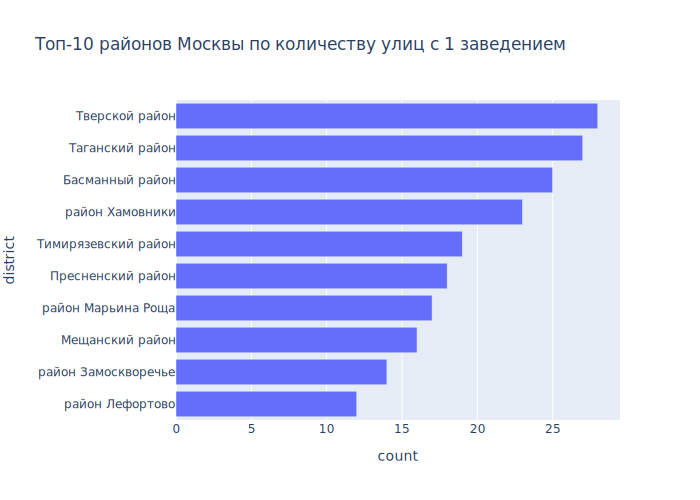

In [61]:
dr = (
    one_obj_street
        .groupby('district', as_index=False)
        .agg({'street':'count'})
        .sort_values(by='street')
        .rename(columns={'street':'count'})
)

fig = px.bar(dr.tail(10), x='count', y='district', orientation='h',
             title='Топ-10 районов Москвы по количеству улиц с 1 заведением')
fig.show()

Тверской и таганский районы лидируют по количеству улиц с 1 заведением - 28 и 27 улиц соответственно.

Нагляднее будет на карте

In [62]:
top10_district_alone = dr.tail(10).reset_index(drop=True)
top10_district_alone

,district,count
0,район Лефортово,12
1,район Замоскворечье,14
2,Мещанский район,16
3,район Марьина Роща,17
4,Пресненский район,18
5,Тимирязевский район,19
6,район Хамовники,23
7,Басманный район,25
8,Таганский район,27
9,Тверской район,28


**не запускать**

In [ ]:
def get_location_yandexgeo1(row):
    district = '+'.join(row['district'].split())

    url = 'https://geocode-maps.yandex.ru/1.x'
    params = {'geocode':'Москва,{}'.format(district),
              'format':'json',
              'apikey': API}

    r = requests.get(url, params=params).json()     

    try:
        pos = r['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
        return pd.Series([float(pos.split()[0]), float(pos.split()[1])])
    except:
        return pd.Series([0, 0])

In [ ]:
tqdm.pandas()

top10_district_alone[['longitude', 'latitude']] = top10_district_alone.progress_apply(get_location_yandexgeo1, axis=1)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [ ]:
top10_district_alone.to_csv('top10_district_alone.csv', encoding='utf-8', index=False)

**Отсюда можно запускать**

In [63]:
url = 'https://drive.google.com/file/d/1yZMcHCkZ4Q4yWIjE_ZeQ0ATQJGvH58xt/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
top10_district_alone = pd.read_csv(path)

In [64]:
top10_district_alone

,district,count,longitude,latitude
0,район Лефортово,12,37.704826,55.753635
1,район Замоскворечье,14,37.634290,55.734162
2,Мещанский район,16,37.628801,55.780071
3,район Марьина Роща,17,37.614383,55.796936
4,Пресненский район,18,37.562389,55.763437
5,Тимирязевский район,19,37.557071,55.825527
6,район Хамовники,23,37.574534,55.729199
7,Басманный район,25,37.671238,55.766572
8,Таганский район,27,37.666971,55.740010
9,Тверской район,28,37.606918,55.770132


In [65]:
moscow = folium.Map(location = [55.755819, 37.617644], zoom_start = 11)

for indice, row in top10_district_alone.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['district']
    ).add_to(moscow)

moscow

*Смотреть по округам смысла нет, т.к. там практически все заведения находятся в центральном округе*

Так же, так как наше заведение будет кафе, то отобразим на карте все кафе, что поможет нам выбрать хорошее место

In [66]:
cafe_data = (
    rest_data
        .query('object_type == "кафе"')
        .groupby('street', as_index=False)
        .agg({'id':'count'})
        .sort_values(by='id', ascending=False)
)

cafe_data

,street,id
944,проспект Мира,103
625,Пресненская набережная,98
632,Профсоюзная улица,87
428,Ленинградский проспект,70
430,Ленинский проспект,64
...,...,...
99,3-я Подрезковская улица,1
710,Солнечная аллея,1
715,Сосновая улица,1
716,Софийская набережная,1


Координаты многих улиц у нас уже есть в датафрейме one_obj_street

In [67]:
one_obj_street

,street,longitude,latitude,region,district
0,1-й Балтийский переулок,37.518560,55.809762,Центральный федеральный округ,район Аэропорт
1,1-й Басманный переулок,37.663458,55.770978,Центральный федеральный округ,Басманный район
3,1-й Ботанический проезд,37.634218,55.849565,Центральный федеральный округ,район Свиблово
4,1-й Вешняковский проезд,37.788567,55.724631,Центральный федеральный округ,Рязанский район
5,1-й Голутвинский переулок,37.612326,55.738287,Центральный федеральный округ,район Якиманка
...,...,...,...,...,...
643,улица Шумилова,37.774310,55.708394,Центральный федеральный округ,район Кузьминки
644,улица Шумкина,37.669594,55.788216,Центральный федеральный округ,район Сокольники
645,улица Щорса,37.406064,55.645934,Центральный федеральный округ,район Солнцево
646,улица Энгельса,37.688081,55.775641,Центральный федеральный округ,Басманный район


In [68]:
cafe_data = pd.merge(cafe_data, one_obj_street[['street', 'longitude', 'latitude']], on='street', how='left')
cafe_data

,street,id,longitude,latitude
0,проспект Мира,103,NaN,NaN
1,Пресненская набережная,98,NaN,NaN
2,Профсоюзная улица,87,NaN,NaN
3,Ленинградский проспект,70,NaN,NaN
4,Ленинский проспект,64,NaN,NaN
...,...,...,...,...
1274,3-я Подрезковская улица,1,37.353701,55.940961
1275,Солнечная аллея,1,37.194717,55.980709
1276,Сосновая улица,1,NaN,NaN
1277,Софийская набережная,1,37.617977,55.747875


In [69]:
cafe_data.query('longitude == longitude')

,street,id,longitude,latitude
750,1-й Митинский переулок,1,37.378692,55.845446
756,проезд Досфлота,1,37.457834,55.845567
757,2-й Новоподмосковный переулок,1,37.509757,55.818114
764,1-я Боевская улица,1,37.693282,55.791830
765,улица Полины Осипенко,1,37.532825,55.779216
...,...,...,...,...
1269,Спортивная улица,1,37.668471,55.609736
1270,3-я Северная линия,1,37.552534,55.942368
1274,3-я Подрезковская улица,1,37.353701,55.940961
1275,Солнечная аллея,1,37.194717,55.980709


Ага, оказывается не так уж и много... 

Остальное тогда вытащу, используя api геокодера

**запускать не нужно**

In [ ]:
tqdm.pandas()

cafe_data[['longitude', 'latitude']] = cafe_data.query('longitude != longitude').progress_apply(get_location_yandexgeo_2, axis=1)

In [ ]:
cafe_data.to_csv('cafe_data.csv', encoding='utf-8', index=False)

**вот отсюда**

In [70]:
url = 'https://drive.google.com/file/d/18Hd2xlbBEkZH4cxXIAJJwNUVUrSJrBXp/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
cafe_data = pd.read_csv(path)

In [71]:
cafe_data

,street,id,longitude,latitude
0,проспект Мира,103,37.637937,55.812368
1,Пресненская набережная,98,37.540991,55.746791
2,Профсоюзная улица,87,37.532511,55.649525
3,Ленинградский проспект,70,37.545635,55.794285
4,Ленинский проспект,64,37.537146,55.682630
...,...,...,...,...
1274,Фитарёвская улица,1,37.480606,55.567107
1275,Коптевский бульвар,1,NaN,NaN
1276,Флотская улица,1,37.498267,55.853026
1277,Конюшковская улица,1,37.577427,55.755996


Функция значит заменила на NaN те 160 строк, что мы заполнили мерджем, так что опять замерджим

In [72]:
cafe_data = pd.merge(cafe_data, one_obj_street[['street', 'longitude', 'latitude']], on='street', how='left')
cafe_data

,street,id,longitude_x,latitude_x,longitude_y,latitude_y
0,проспект Мира,103,37.637937,55.812368,NaN,NaN
1,Пресненская набережная,98,37.540991,55.746791,NaN,NaN
2,Профсоюзная улица,87,37.532511,55.649525,NaN,NaN
3,Ленинградский проспект,70,37.545635,55.794285,NaN,NaN
4,Ленинский проспект,64,37.537146,55.682630,NaN,NaN
...,...,...,...,...,...,...
1274,Фитарёвская улица,1,37.480606,55.567107,NaN,NaN
1275,Коптевский бульвар,1,NaN,NaN,37.525154,55.831069
1276,Флотская улица,1,37.498267,55.853026,NaN,NaN
1277,Конюшковская улица,1,37.577427,55.755996,NaN,NaN


In [73]:
cafe_data = (
    cafe_data
        .fillna(
            {'longitude_x':cafe_data['longitude_y'],
             'latitude_x':cafe_data['latitude_y']})
        .drop(
            columns=['longitude_y', 'latitude_y'])
        .rename(columns={'longitude_x':'longitude',
                         'latitude_x':'latitude'})
)

cafe_data

,street,id,longitude,latitude
0,проспект Мира,103,37.637937,55.812368
1,Пресненская набережная,98,37.540991,55.746791
2,Профсоюзная улица,87,37.532511,55.649525
3,Ленинградский проспект,70,37.545635,55.794285
4,Ленинский проспект,64,37.537146,55.682630
...,...,...,...,...
1274,Фитарёвская улица,1,37.480606,55.567107
1275,Коптевский бульвар,1,37.525154,55.831069
1276,Флотская улица,1,37.498267,55.853026
1277,Конюшковская улица,1,37.577427,55.755996


Датафрейм готов

In [74]:
moscow = folium.Map(location = [55.755819, 37.617644], zoom_start = 11)

coordinates = []

latitudes = list(cafe_data['latitude'])
longitudes = list(cafe_data['longitude'])

for lat, lng in zip(latitudes, longitudes):
    coordinates.append([lat, lng])

moscow.add_child(plugins.HeatMap(coordinates))

### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Какие закономерности можно выявить?


In [75]:
number_top10 = (
    rest_data
        .query('street in @top10_street.street')
        .groupby('street')
        ['number'].agg(['count', 'sum', 'mean'])
)

number_top10['mean'] = (np.ceil(number_top10['mean'])).astype('int')
number_top10

,count,sum,mean
street,,,
Варшавское шоссе,160,8456,53
Кировоградская улица,107,6409,60
Кутузовский проспект,114,9697,86
Ленинградский проспект,170,8970,53
Ленинский проспект,146,9080,63
Пресненская набережная,167,7656,46
Профсоюзная улица,178,8355,47
Ходынский бульвар,102,1933,19
проспект Вернадского,126,8612,69


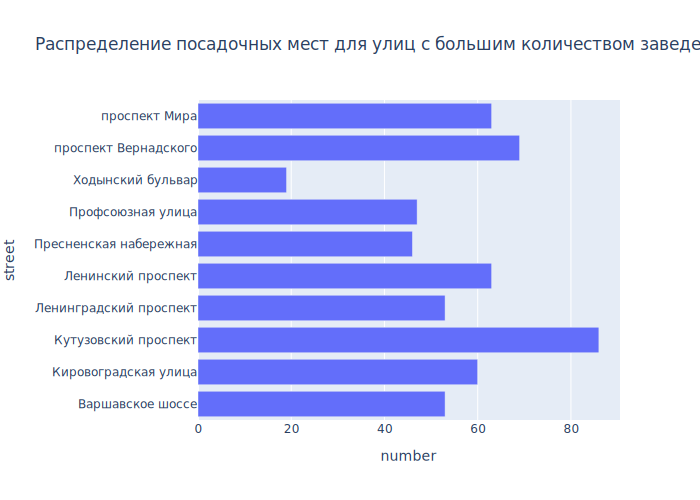

In [76]:
fig = px.bar(number_top10, orientation='h',
             y=number_top10.index, x='mean',
             title='Распределение посадочных мест для улиц с большим количеством заведений')

fig.update_layout(
    xaxis_title='number'
)

fig.show()

In [77]:
int(np.ceil(number_top10['mean'].mean()))

56

Для улиц с большим количество объектов характерны заведения с большим количеством посадочных мест (в среднем по 56 мест).

# Общий вывод и рекомендации

1. 40% всех заведений Москвы - это кафе. Сильная конкуренция для нас. Рестораны занимают 15%. В принципе можно и ресторан открыть, а не кафе.
2. У кафе и ресторанов примерно одинаковое количество сетевых заведений - в районе 23%. Для нас несомненный плюс - сетевые заведения довольно серьезные конкуренты, и могли бы спокойно выдавить нас с рынка на начальном этапе.
3. Лидер по сетевым заведениям - предприятия быстрого обслуживания. По сути они не наши прямые конкуренты, так что страшиться нам нечего.
4. В среднем в кафе по 30 посадочных мест, в ресторанах - 80. Для нас эти цифры будет наглядным ориентиром. Больше 80 посадочных мест делать не нужно, но и меньше 30 определенно точно не стоит. 50 вполне приемлемо.
5. Судя по тепловой карте топ-10 улиц по количеству заведений, кафе/ресторан нам открывать лучше на Юго-Востоке Москвы. Меньше заведений - меньше конкуренция.

Итак, открываем кафе/ресторан на Юго-Востоке Москвы на 50 посадочных мест.



Презентация: https://disk.yandex.ru/i/cy-t_LTgvWbFAg